In [1]:
import pandas as pd
import os

# Load the dataset
os.chdir("..")
data_path = 'datasets'
df = pd.read_csv(os.path.join(data_path, 'wine_quality_cleaned.csv'), index_col=0)

# Display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 998 entries, US to US
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   description        998 non-null    object 
 1   points             998 non-null    int64  
 2   price              998 non-null    float64
 3   variety            998 non-null    object 
 4   description_clean  998 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 46.8+ KB


In [2]:
df = df.reset_index()

/tmp/ipykernel_376887/3762995358.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["country"], palette="viridis")


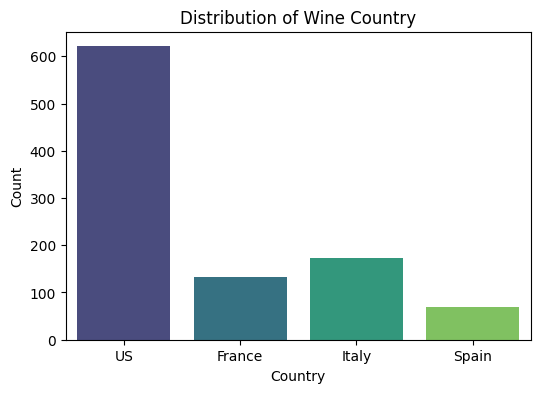

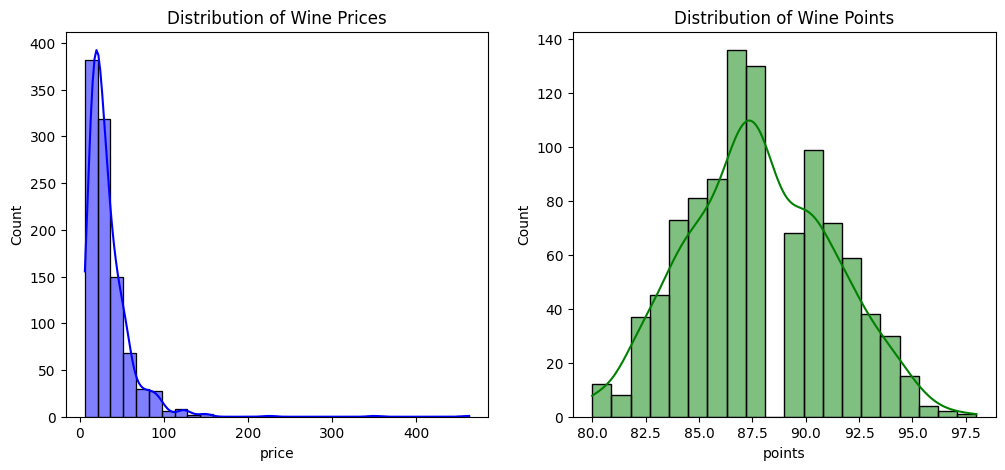

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot country distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df["country"], palette="viridis")
plt.title("Distribution of Wine Country")
plt.xlabel("Country")
plt.ylabel("Count")
plt.show()

# Plot price and points distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df["price"], bins=30, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Distribution of Wine Prices")

sns.histplot(df["points"], bins=20, kde=True, ax=axes[1], color="green")
axes[1].set_title("Distribution of Wine Points")

plt.show()

# NLP EDA

In [4]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

# Preprocess text (remove punctuation, convert to lowercase)
def preprocess(text):
    text = re.sub(r"[^\w\s]", "", text.lower())  # Remove punctuation
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return words

# Apply preprocessing to all descriptions
all_words = [word for text in df["description_clean"] for word in preprocess(text)]
word_counts = Counter(all_words)

# Display top 20 words
word_counts.most_common(20)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jonnyoh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('wine', 627),
 ('flavor', 575),
 ('fruit', 456),
 ('cherry', 310),
 ('finish', 239),
 ('tannin', 234),
 ('acidity', 212),
 ('aroma', 195),
 ('dry', 189),
 ('oak', 172),
 ('black', 171),
 ('ripe', 165),
 ('note', 159),
 ('spice', 155),
 ('blackberry', 155),
 ('sweet', 152),
 ('drink', 142),
 ('palate', 142),
 ('rich', 137),
 ('red', 132)]

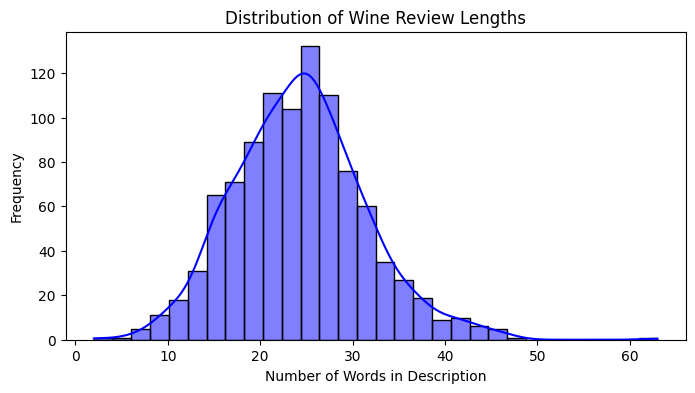

In [6]:
#  Distribution of Review Lengths
df["text_length"] = df["description_clean"].apply(lambda x: len(x.split()))

# Plot histogram of text lengths
plt.figure(figsize=(8, 4))
sns.histplot(df["text_length"], bins=30, kde=True, color="blue")
plt.xlabel("Number of Words in Description")
plt.ylabel("Frequency")
plt.title("Distribution of Wine Review Lengths")
plt.show()

# (Add review length as a new feature.)


In [7]:
#  Most Common Bigrams (Two-Word Phrases)
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2,2), stop_words="english", max_features=20)
X_ngrams = vectorizer.fit_transform(df["description_clean"])

# Get top bigrams
bigram_counts = pd.DataFrame({"Bigram": vectorizer.get_feature_names_out(), "Count": X_ngrams.toarray().sum(axis=0)})
bigram_counts = bigram_counts.sort_values(by="Count", ascending=False)

# Display top 10 bigrams
bigram_counts.head(10)


,Bigram,Count
12,fruit flavor,64
1,black cherry,55
6,cabernet sauvignon,37
14,pinot noir,34
5,blackberry cherry,31
3,black fruit,30
10,flavor blackberry,26
2,black currant,26
8,cherry fruit,26
9,crisp acidity,24


In [8]:
# IMPORTANT WORDS: TF-IDF helps determine which words are unique to certain wine descriptions
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=20, stop_words="english")
X_tfidf = tfidf_vectorizer.fit_transform(df["description_clean"])

# Get top words by TF-IDF score
tfidf_scores = pd.DataFrame({"Word": tfidf_vectorizer.get_feature_names_out(), "TF-IDF Score": X_tfidf.toarray().mean(axis=0)})
tfidf_scores = tfidf_scores.sort_values(by="TF-IDF Score", ascending=False)

# Display top 10 words by TF-IDF score
tfidf_scores.head(10)

# (Remove common generic words (e.g., "wine", "flavor", "taste").)
# (Identify country-specific words and use them as features.)


,Word,TF-IDF Score
19,wine,0.204563
8,flavor,0.190218
9,fruit,0.164643
4,cherry,0.120108
7,finish,0.104140
0,acidity,0.100477
18,tannin,0.098733
6,dry,0.090771
1,aroma,0.090339
11,oak,0.081094


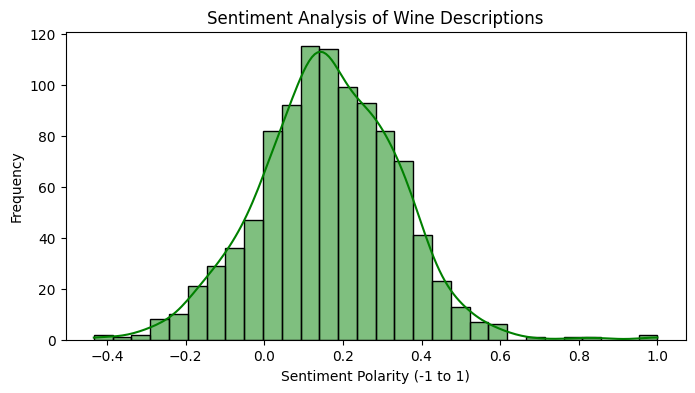

In [9]:
from textblob import TextBlob

df["sentiment"] = df["description_clean"].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot sentiment distribution
plt.figure(figsize=(8, 4))
sns.histplot(df["sentiment"], bins=30, kde=True, color="green")
plt.xlabel("Sentiment Polarity (-1 to 1)")
plt.ylabel("Frequency")
plt.title("Sentiment Analysis of Wine Descriptions")
plt.show()


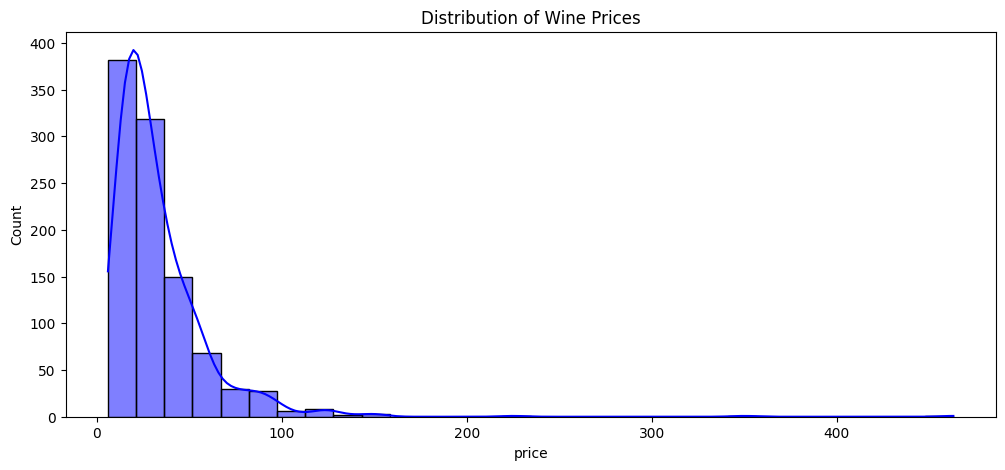

In [12]:
# Create the figure
fig, ax = plt.subplots(figsize=(12, 5))

# Plot price distribution
sns.histplot(df["price"], bins=30, kde=True, ax=ax, color="blue")
ax.set_title("Distribution of Wine Prices")

# Show the plot
plt.show()

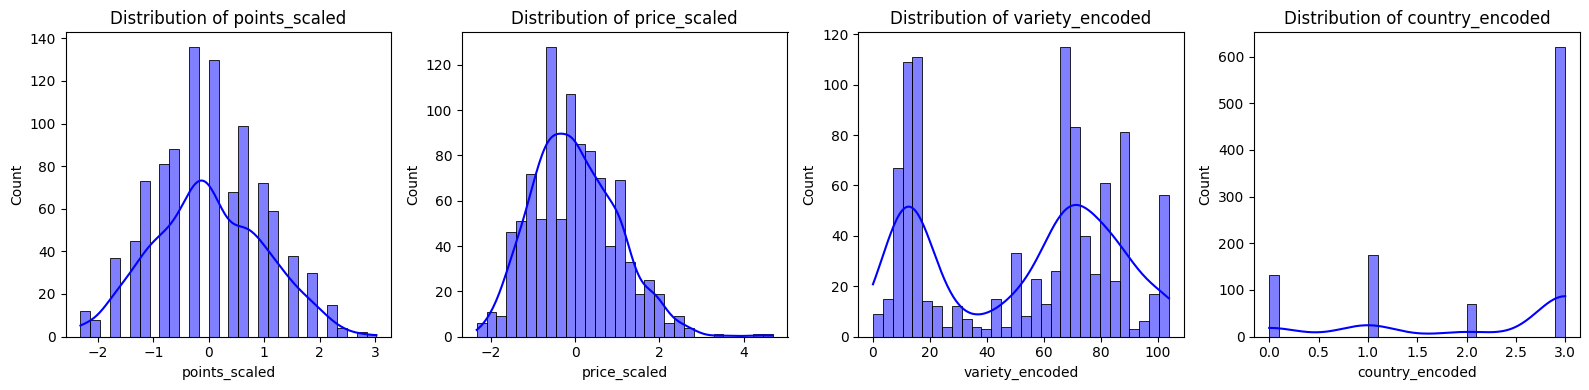

In [15]:
# Select only the transformed numerical features for visualization
transformed_features = ["points_scaled", "price_scaled", "variety_encoded", "country_encoded"]

# Generate summary statistics
summary_stats = df[transformed_features].describe()

# Plot histograms for numerical features
fig, axes = plt.subplots(1, len(transformed_features), figsize=(16, 4))

for i, feature in enumerate(transformed_features):
    sns.histplot(df[feature], bins=30, kde=True, ax=axes[i], color="blue")
    axes[i].set_title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()

In [16]:
# Train-test split (80% train, 20% test)
X = df[["points_scaled", "price_scaled", "variety_encoded"]]  # Feature set (no text yet)
y = df["country_encoded"]  # Target variable
